In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from scipy import stats


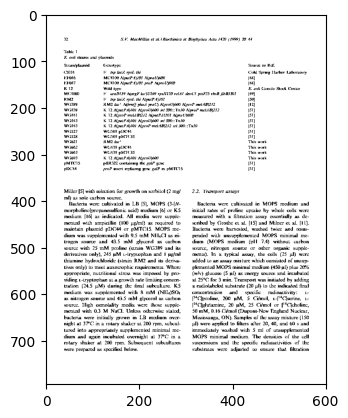

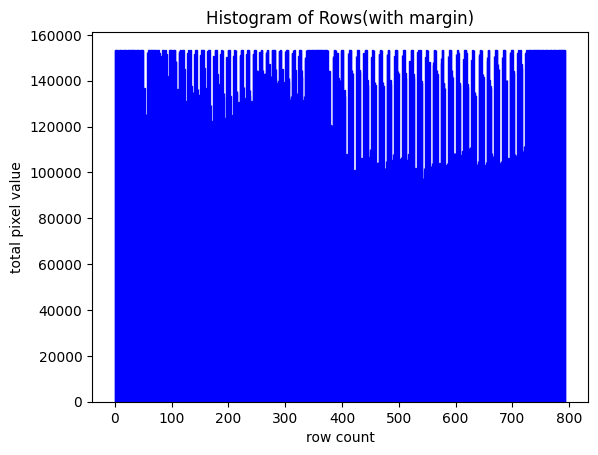

In [12]:
img = cv2.imread('paper10.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(imgray, 170, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.show()

array = np.array(thresh)
array.shape

row_sums = np.sum(array, axis=1)


indices = np.arange(len(row_sums))

plt.bar(indices, row_sums, edgecolor='blue')

plt.title('Histogram of Rows(with margin)')
plt.xlabel('row count')
plt.ylabel('total pixel value')

plt.show()

In [22]:
########       Trim the top and bottom white margin     ############

def trim_white_margins(pixel_array):
    row_sums = np.sum(pixel_array, axis=1)
    num_columns = pixel_array.shape[1]
    white_row_sum = 255 * num_columns

    # Find the first non-white row from the top
    start_index = 0
    while start_index < len(row_sums) and row_sums[start_index] == white_row_sum:
        start_index += 1

    # Find the first non-white row from the bottom
    end_index = len(row_sums) - 1
    while end_index >= 0 and row_sums[end_index] == white_row_sum:
        end_index -= 1

    # Trim the pixel array
    row_trimmed_array = pixel_array[start_index:end_index+1, :]

    return row_trimmed_array,start_index


######### Crop out the left and right margin ###########
def trim_white_margins_lr(pixel_array):
    col_sums = np.sum(pixel_array, axis=0)
    num_rows = pixel_array.shape[0]
    white_col_sum = 255 * num_rows

    # Find the first non-white column from the left
    start_index = 0
    while start_index < len(col_sums) and col_sums[start_index] == white_col_sum:
        start_index += 1

    # Find the first non-white column from the right
    end_index = len(col_sums) - 1
    while end_index >= 0 and col_sums[end_index] == white_col_sum:
        end_index -= 1

    # Trim the pixel array
    col_trimmed_array = pixel_array[:, start_index:end_index+1]

    return col_trimmed_array

row_trimmed_array,top_margin = trim_white_margins(array)
marginless_array = trim_white_margins_lr(row_trimmed_array)

# print("Marginless Array:")
# print(marginless_array)
marginless_array.shape

#Top Margin
# top_margin = array.shape[0] - marginless_array.shape[0]
print(top_margin)



51


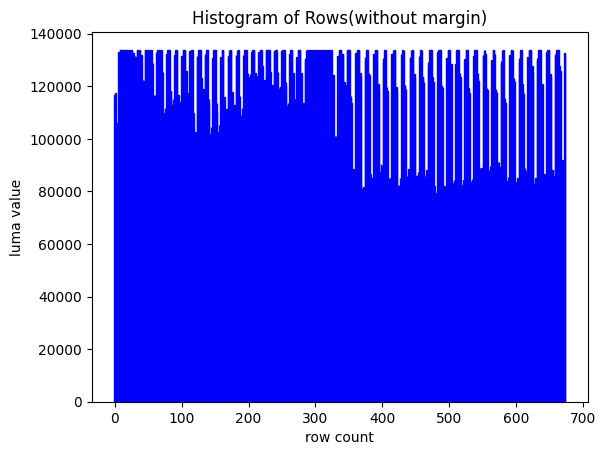

In [23]:
row_sums = np.sum(marginless_array, axis=1)
indices = np.arange(len(row_sums))

plt.bar(indices, row_sums, edgecolor='blue')

plt.title('Histogram of Rows(without margin)')
plt.xlabel('row count')
plt.ylabel('luma value')

plt.show()


In [24]:
marginless_array_row_sums = np.sum(marginless_array, axis=1)
print (marginless_array_row_sums.shape)

def convert_non_255_to_zero(marginless_array, marginless_array_row_sums):
  new_arr = np.where(marginless_array_row_sums != 255*marginless_array.shape[1], 0, marginless_array_row_sums)
  return new_arr

# Convert non-255 values to 0 and store in another array
marginless_array_improved_row_sum = convert_non_255_to_zero(marginless_array, marginless_array_row_sums)

(674,)


12.8
Average Line Gap Height: 4
Significant Gaps (row indices): [(8, 27), (286, 325)]
[(0, 8), (27, 286), (325, 674)]


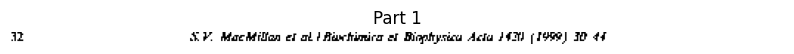

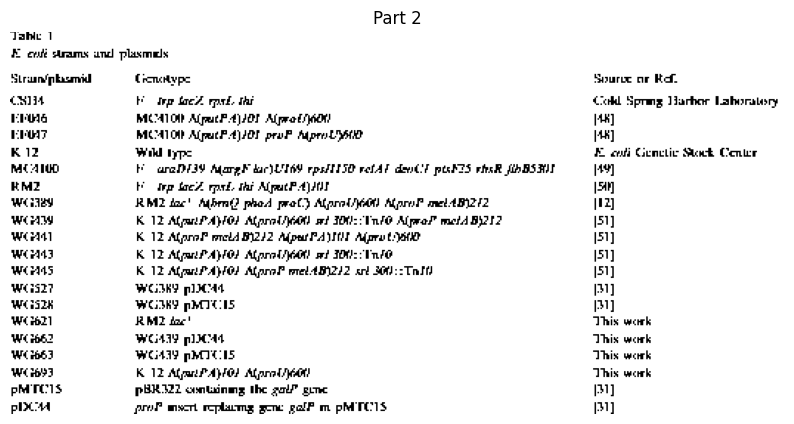

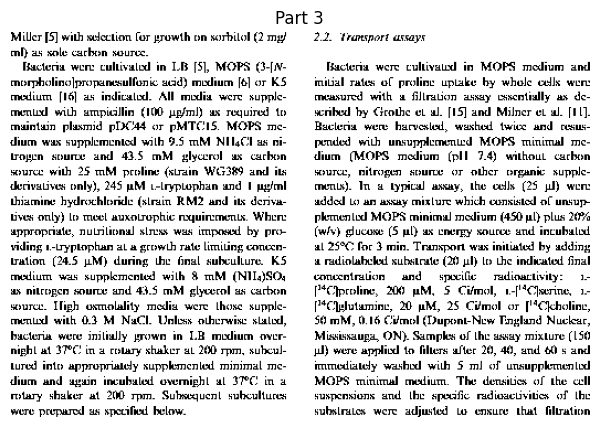

In [25]:
def calculate_row_sums(image, threshold=255):
    num_rows, num_columns = image.shape
    white_row_sum = threshold * num_columns
    row_sums = np.sum(image, axis=1)
    return row_sums, white_row_sum

def identify_line_gaps(row_sums, white_row_sum):
    white_space_lengths = []
    current_length = 0

    for value in row_sums:
        if value == white_row_sum:
            current_length += 1
        else:
            if current_length > 0:
                white_space_lengths.append(current_length)
                current_length = 0

    if current_length > 0:
        white_space_lengths.append(current_length)

    if white_space_lengths:
      mode_result = stats.mode(white_space_lengths)
        # Check if the mode result contains any mode value
      if mode_result.mode.size > 0:
          average_line_gap = mode_result.mode
      #  average_line_gap = stats.mode(white_space_lengths).mode[0]#mode
    else:
        average_line_gap = 0

    return average_line_gap, white_space_lengths, white_space_lengths #mode

def find_significant_gaps(row_sums, white_row_sum, average_line_gap, gap_multiplier=3.2):#mode
    significant_gaps = []
    current_length = 0
    significant_threshold = average_line_gap * gap_multiplier #mode
    print(significant_threshold)

    for i, value in enumerate(row_sums):
        if value == white_row_sum:
            current_length += 1
        else:
            if current_length >= significant_threshold:
                significant_gaps.append((i - current_length, i))
            current_length = 0

    if current_length > significant_threshold:
        significant_gaps.append((len(row_sums) - current_length, len(row_sums)))

    return significant_gaps
    #print(significant_gaps)

def divide_image(image, significant_gaps):
    parts = []
    start = 0
    for gap_start, gap_end in significant_gaps:
        parts.append((start, gap_start))
        start = gap_end
    parts.append((start, image.shape[0]))
    return parts

row_sums, white_row_sum = calculate_row_sums(marginless_array)
average_line_gap, white_space_lengths, white_pixel_row_array = identify_line_gaps(row_sums, white_row_sum)
significant_gaps = find_significant_gaps(row_sums, white_row_sum, average_line_gap) #mode


print("Average Line Gap Height:", average_line_gap) #mode

print("Significant Gaps (row indices):", significant_gaps)
#print("Line gap mode count", mode_count)


parts = divide_image(marginless_array, significant_gaps)
print(parts)
# for i, part in enumerate(parts):
#     print(f"Part {i + 1} shape:", part.shape)




def display_image_parts_separately(image, parts):
    for i, (start, end) in enumerate(parts):
        part = image[start:end, 0:image.shape[1]]
        plt.figure(figsize=(10, 5))
        plt.imshow(part, cmap='gray')
        plt.axis('off')
        plt.title(f'Part {i + 1}')
        plt.show()

display_image_parts_separately(marginless_array, parts)


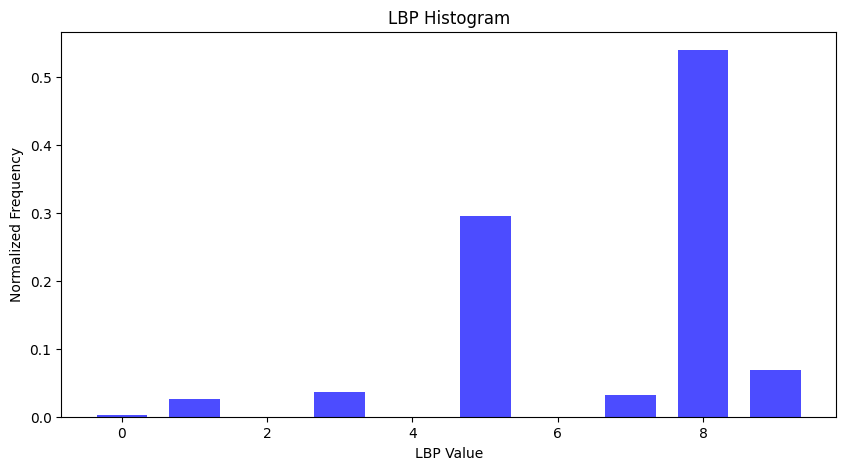

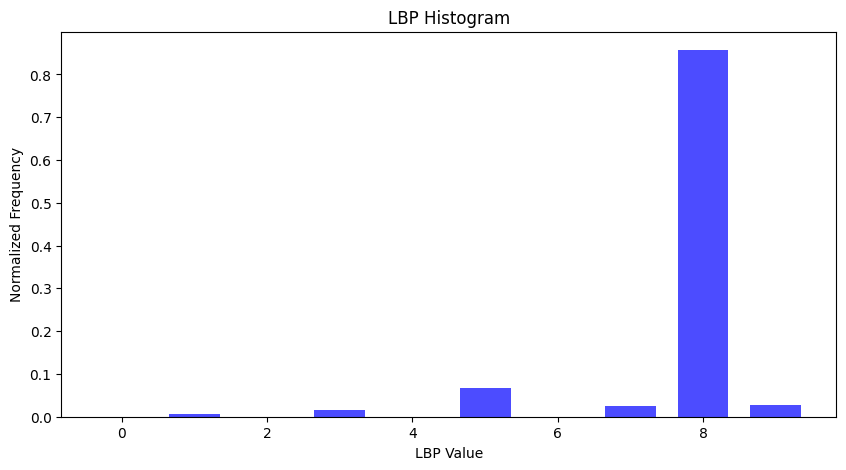

Part from rows 27 to 286 likely contains figures.


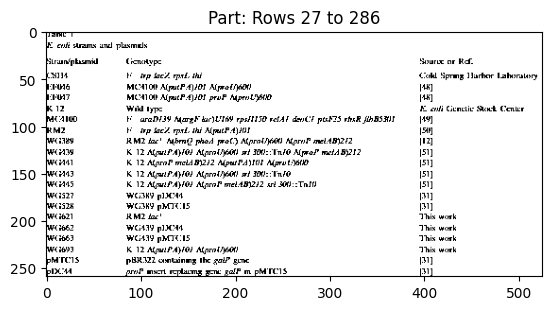

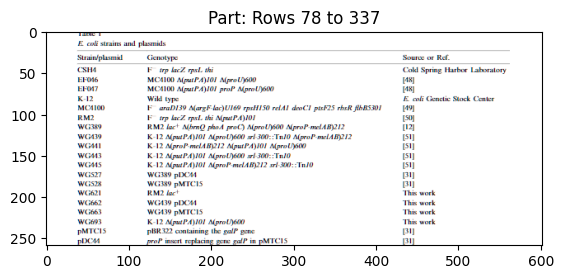

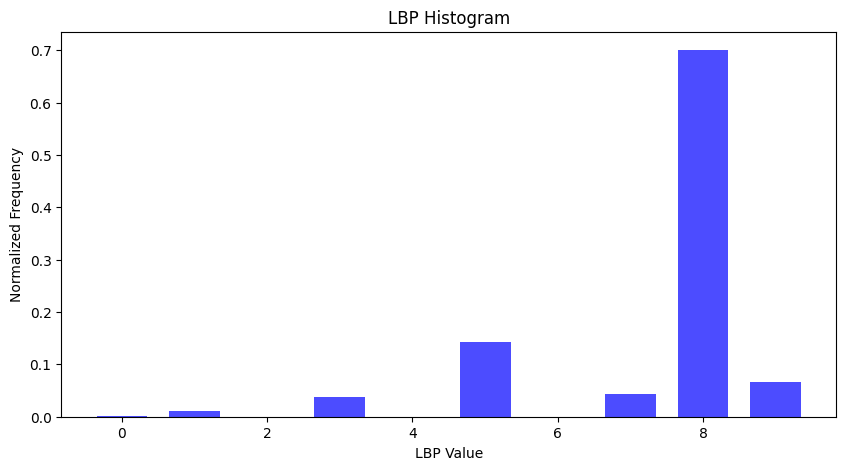

In [26]:
# Function to analyze texture using Local Binary Patterns (LBP)
def analyze_texture(image_part, P=8, R=1):
    lbp = local_binary_pattern(image_part, P, R, method='uniform')
    return lbp

# Function to determine if the texture is significant
def has_significant_texture(lbp, threshold=0.75):
    P = 8
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram


    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(0, P + 2), hist, width=0.7, color='blue', alpha=0.7)
    plt.title("LBP Histogram")
    plt.xlabel("LBP Value")
    plt.ylabel("Normalized Frequency")
    plt.show()

    return hist.max() > threshold

def display_image_parts(image, parts):
    for i, (start, end) in enumerate(parts):
        part = image[start:end, 0:image.shape[1]]
        plt.figure()
        plt.imshow(part, cmap='gray')
        plt.title(f'Part {i+1}: Rows {start} to {end}')
        plt.show()


# Load the image (assuming it's already loaded as 'image')
# Assuming 'image' is a 2D numpy array (grayscale)


for start, end in parts:
    part = marginless_array[start:end, 0:marginless_array.shape[1]]
    lbp = analyze_texture(part)
    if has_significant_texture(lbp):
        print(f"Part from rows {start} to {end} likely contains figures.")

        plt.figure()
        plt.imshow(part, cmap='gray')
        plt.title(f'Part: Rows {start} to {end}')
        plt.show()

        part = img[start+top_margin:end+ top_margin, 0:array.shape[1]]
        plt.figure()
        plt.imshow(part, cmap='gray')
        plt.title(f'Part: Rows {start+top_margin} to {end+top_margin}')
        plt.show()




